In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [136]:
def polynomial(degree):
    def _polynomial(x, _x):
        return np.dot(x, _x.T) ** degree
    return _polynomial

def sigmoid(x, _x):
    result = 1. / (1. + np.exp(-np.dot(x, _x.T)))
#     print(result.shape)
    return result


def rbf(beta):
    def _rbf(x, y):
        if np.ndim(x) == 1 and np.ndim(y) == 1:
            result = np.exp(-beta * (np.linalg.norm(x - y, 2)) ** 2)
        elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
            result = np.exp(-beta * (np.linalg.norm(x - y, 2, axis=1) ** 2))
        elif np.ndim(x) > 1 and np.ndim(y) > 1:
            result = np.exp(-beta * (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2))
        return result
    return _rbf

## SMO Implementation
### [original paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

In [149]:
class SMOModel:
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               
        self.y = y              
        self.C = C               
        self.kernel = kernel     
        self.alphas = alphas     
        self.b = b               
        self.errors = errors     
        self._obj = []           
        self.m = len(self.X)
   

\begin{equation*}
max_{\alpha}W(\alpha) = \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j \langle x^{(i)}, x^{(j)} \rangle \\
0 \leq \alpha_{i} \leq C, i = 1,...,m \\
\sum_{i=1}^m \alpha_{i} y^{(i)} = 0
\end{equation*}

In [152]:
def objective_function(alphas, target, kernel, X_train):
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))

\begin{equation*}
f(x) = \sum_{i=1}^m \alpha_{i} y^{(i)} \langle x^{(i)}, x^{(j)} \rangle + b
\end{equation*}

In [ ]:
def decision_function(alphas, target, kernel, X_train, x_test, b):
    result = np.dot((alphas * target), kernel(X_train, x_test)) - b
    return result

In [126]:
def take_step(i1, i2, model):    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model

    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2

    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new alpha 2 (a2) if eta is negative
    if eta < 0:
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H

    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2

    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < model.C:
        b_new = b1
    elif 0 < a2 and a2 < model.C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new

    # Update model threshold
    model.b = b_new

    return 1, model

In [127]:
def examine_example(i2, model):

    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model

In [128]:
def train(model):

    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return model

In [129]:
def calc_weights(model):
    return np.dot(model.alphas * model.y, model.X)

In [130]:
def predict(model, weights, X):
    return np.dot(weights, X.T) - np.array([model.b for _ in range(len(X))])

In [131]:
chips_df = pd.read_csv('../input/chips.csv')
geyser_df = pd.read_csv('../input/geyser.csv')

random_state = 1337

In [153]:
def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.X[mask,0], model.X[mask,1],
                   c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

In [147]:
def eval_svm(X, y):
    kernels = {
        'poly1': polynomial(1),
        'poly2': polynomial(2),
        'poly3': polynomial(3),
        'poly4': polynomial(4),
        'poly5': polynomial(5),
        'rbf-default': rbf(1. / X.shape[1]),
        'rbf1': rbf(1),
        'rbf-1': rbf(0.1),
        'rbf-2': rbf(1e-2),
    }
    n_splits = 4
    best_score = 0
    best_kernel = None

    for kernel in kernels:
        mean_score = 0
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        for train_indices, test_indices in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
            C = 1000.0
            m = len(X_train)
            initial_alphas = np.zeros(m)
            initial_b = 0.0

            # Instantiate model
            model = SMOModel(X_train, y_train, C, kernels[kernel],
                             initial_alphas, initial_b, np.zeros(m))

            # Initialize error cache
            initial_error = decision_function(model.alphas, model.y, model.kernel,
                                              model.X, model.X, model.b) - model.y
            model.errors = initial_error
            trained_model = train(model)
            weights = calc_weights(model)
            y_pred = predict(model, weights, X_test)
            
            mean_score += roc_auc_score(y_test, y_pred)
        mean_score /= n_splits
        if mean_score > best_score:
            best_score = mean_score
            best_kernel = kernel
        print('ROC-AUC score for {} = {:.5f}'.format(kernel, mean_score))
    print('best kernel is {}'.format(best_kernel))

In [148]:
# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

X = chips_df.drop('class', axis=1).to_numpy()
y = chips_df['class'].replace('N', -1).replace('P', 1).to_numpy()
X = MinMaxScaler().fit_transform(X)
eval_svm(X, y)

ROC-AUC score for poly1 = 0.41719
ROC-AUC score for poly2 = 0.40749
ROC-AUC score for poly3 = 0.43456
ROC-AUC score for poly4 = 0.46899
ROC-AUC score for poly5 = 0.45332
ROC-AUC score for rbf-default = 0.42844
ROC-AUC score for rbf1 = 0.54436
ROC-AUC score for rbf-1 = 0.56997
ROC-AUC score for rbf-2 = 0.48205
best kernel is rbf-1


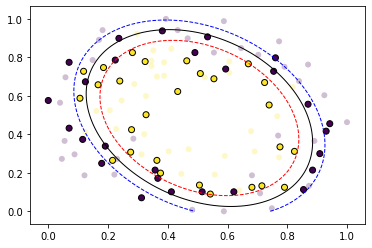

In [151]:
C = 1000.0
m = len(X)
initial_alphas = np.zeros(m)
initial_b = 0.0
# Instantiate model
model = SMOModel(X, y, C, rbf(0.1),
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error


np.random.seed(0)
output = train(model)

fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [93]:
# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

X = geyser_df.drop('class', axis=1).to_numpy()
y = geyser_df['class'].replace('N', -1).replace('P', 1).to_numpy()
X = MinMaxScaler().fit_transform(X)
eval_svm(X, y)

ROC-AUC score for poly1 = 0.93347
ROC-AUC score for poly2 = 0.91493
ROC-AUC score for poly3 = 0.88861
ROC-AUC score for poly4 = 0.92143
ROC-AUC score for poly5 = 0.92209
ROC-AUC score for sigmoid = 0.75745
best kernel is poly1


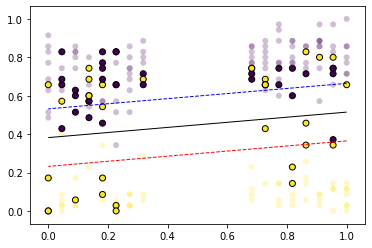

In [100]:
C = 1
m = len(X)
initial_alphas = np.zeros(m)
initial_b = 0.0
# Instantiate model
model = SMOModel(X, y, C, polynomial(1),
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error


np.random.seed(0)
output = train(model)

fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)